In [1]:
import os
import glob
import pandas as pd
import numpy as np
import sys
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# all class ver.
# load dataset (pickle files)

input_path1 = 'C:/Users/LG/Desktop/frost_data/ver3/SMOTE/73class'
input_path2 = 'C:/Users/LG/Desktop/frost_data/ver3/ML_kma/ML_kma'
input_path3 = 'C:/Users/LG/Desktop/frost_data/ver3/ML_kma/re_kma_data'

for i in [93, 102, 104, 108, 112, 119, 131, 133, 136, 143, 146, 156, 177, 296]:
    with open(f'{input_path2}/site{i}.pkl','rb') as f3:
        test = pickle.load(f3)
                 
    test1 = test[73*0+9:73*0+21,:]
    test2 = test[73*0+33:73*0+45,:]
    test3 = test[73*1+3:73*1+15,:]
    test4 = test[73*1+27:73*1+39,:]
    test5 = test[73*2+21:73*2+33,:]
    test6 = test[73*2+45:73*2+57,:]
    test_new = np.vstack((test1,test2,test3,test4,test5,test6))
    k = 73*3
    j = 6
    while k + 73*4 < test.size:
        test1 = test[k+15:k+27,:]
        test2 = test[k+39:k+51,:]
        test3 = test[k+73+9:k+73+21,:]
        test4 = test[k+73+33:k+73+45,:]
        test5 = test[k+73*2+3:k+73*2+15,:]
        test6 = test[k+73*2+27:k+73*2+39,:]
        test7 = test[k+73*3+21:k+73*3+33,:]
        test8 = test[k+73*3+45:k+73*3+57,:]
        k += 73*4
        test_new = np.vstack((test_new,test1,test2,test3,test4,test5,test6,test7,test8))
        j += 8

    kma_info_list = glob.glob(f'{input_path3}/re_kma_SITE{i}.csv',recursive=True)
    kma_info = pd.read_csv(kma_info_list[0])
    frost1 = float(kma_info.frost.tolist()[1])
    frost2 = float(kma_info.frost.tolist()[2])
    frost3 = float(kma_info.frost.tolist()[3])
    frost = np.array([frost1, frost2, frost1, frost2, frost2, frost3])
    d_i = 6
    d_k = 1
    while d_k < 147:
        frost1 = float(kma_info.frost.tolist()[d_k+1])
        frost2 = float(kma_info.frost.tolist()[d_k+2])
        frost3 = float(kma_info.frost.tolist()[d_k+3])
        #print(d_k)
        d_k += 1
        d_i += 8
        frost_od = np.array([frost1, frost2, frost1, frost2, frost1, frost2, frost2, frost3])
        frost = np.hstack((frost,frost_od))    
    
    if i == 93:
        total_te = test_new
        total_f = frost
    else:
        total_te = np.vstack((total_te,test_new))
        total_f = np.hstack((total_f,frost))


for i in range(0,73):
    with open(f'{input_path1}/X_train_T{i}.pkl','rb') as f1:
        X_train_od = pickle.load(f1)
    with open(f'{input_path1}/Y_train_T{i}.pkl','rb') as f2:
        Y_train_od = pickle.load(f2) 
    if i == 0:
        X_train = X_train_od
        Y_train = Y_train_od
    else:
        X_train = np.vstack((X_train,X_train_od))
        Y_train = np.hstack((Y_train,Y_train_od))
with open(f'C:/Users/LG/Desktop/frost_data/ver3/SMOTE/1class/scaler.pkl','rb') as f3:
    scaler = pickle.load(f3)
X_test = total_te[:,:-1]
print(X_test.shape)
print(total_f.shape)
X_test = scaler.transform(X_test)
Y_train = Y_train.T
print('Finish setting data')

(197232, 8)
(16436,)
Finish setting data


In [3]:
clf = RandomForestClassifier(n_estimators=130, max_depth=3, random_state = 0)
model = clf.fit(X_train, Y_train)

In [4]:
test_pb = model.predict(X_test)

In [5]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 1 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.mean(F1)
ACC_tb = np.mean(ACC)
PRE_tb = np.mean(PRE)
REC_tb = np.mean(REC)
CSI_tb = np.mean(CSI)
SPC_tb = np.mean(SPC)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]

--------- Verification -----------
--------- check time:  1 -----------
Mean values, F1:0.559787, acc:0.576369, pre:0.457718, rec:0.720449, csi:0.388688, spc:0.490338
Max values, F1:0.565934, acc:0.581924, pre:0.462417, rec:0.732848, csi:0.394636, spc:0.497977
Min values, F1:0.551879, acc:0.569447, pre:0.451710, rec:0.709131, csi:0.381100, spc:0.484625


In [6]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 2 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.hstack((F1_tb,np.mean(F1)))
ACC_tb = np.hstack((ACC_tb,np.mean(ACC)))
PRE_tb = np.hstack((PRE_tb,np.mean(PRE)))
REC_tb = np.hstack((REC_tb,np.mean(REC)))
CSI_tb = np.hstack((CSI_tb,np.mean(CSI)))
SPC_tb = np.hstack((SPC_tb,np.mean(SPC)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]

--------- Verification -----------
--------- check time:  2 -----------
Mean values, F1:0.595320, acc:0.569926, pre:0.459205, rec:0.846124, csi:0.423813, spc:0.405006
Max values, F1:0.598653, acc:0.573437, pre:0.461758, rec:0.853126, csi:0.427199, spc:0.409164
Min values, F1:0.591534, acc:0.565457, pre:0.456031, rec:0.840420, csi:0.419985, spc:0.400566


In [7]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 3 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.hstack((F1_tb,np.mean(F1)))
ACC_tb = np.hstack((ACC_tb,np.mean(ACC)))
PRE_tb = np.hstack((PRE_tb,np.mean(PRE)))
REC_tb = np.hstack((REC_tb,np.mean(REC)))
CSI_tb = np.hstack((CSI_tb,np.mean(CSI)))
SPC_tb = np.hstack((SPC_tb,np.mean(SPC)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]

--------- Verification -----------
--------- check time:  3 -----------
Mean values, F1:0.600489, acc:0.562900, pre:0.456103, rec:0.878636, csi:0.429071, spc:0.374372
Max values, F1:0.602730, acc:0.565204, pre:0.457629, rec:0.883280, csi:0.431363, spc:0.377301
Min values, F1:0.597454, acc:0.559440, pre:0.453722, rec:0.874471, csi:0.425978, spc:0.370827


In [8]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 4 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.hstack((F1_tb,np.mean(F1)))
ACC_tb = np.hstack((ACC_tb,np.mean(ACC)))
PRE_tb = np.hstack((PRE_tb,np.mean(PRE)))
REC_tb = np.hstack((REC_tb,np.mean(REC)))
CSI_tb = np.hstack((CSI_tb,np.mean(CSI)))
SPC_tb = np.hstack((SPC_tb,np.mean(SPC)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]

--------- Verification -----------
--------- check time:  4 -----------
Mean values, F1:0.601706, acc:0.558321, pre:0.453874, rec:0.892360, csi:0.430315, spc:0.358864
Max values, F1:0.604152, acc:0.560517, pre:0.455413, rec:0.897171, csi:0.432821, spc:0.362128
Min values, F1:0.599555, acc:0.555830, pre:0.452196, rec:0.889039, csi:0.428117, spc:0.355452


In [9]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 5 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.hstack((F1_tb,np.mean(F1)))
ACC_tb = np.hstack((ACC_tb,np.mean(ACC)))
PRE_tb = np.hstack((PRE_tb,np.mean(PRE)))
REC_tb = np.hstack((REC_tb,np.mean(REC)))
CSI_tb = np.hstack((CSI_tb,np.mean(CSI)))
SPC_tb = np.hstack((SPC_tb,np.mean(SPC)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]

--------- Verification -----------
--------- check time:  5 -----------
Mean values, F1:0.601868, acc:0.555081, pre:0.452228, rec:0.899514, csi:0.430481, spc:0.349417
Max values, F1:0.603731, acc:0.557350, pre:0.453724, rec:0.903778, csi:0.432389, spc:0.352620
Min values, F1:0.599751, acc:0.552473, pre:0.450515, rec:0.896324, csi:0.428317, spc:0.346247


In [10]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 6 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.hstack((F1_tb,np.mean(F1)))
ACC_tb = np.hstack((ACC_tb,np.mean(ACC)))
PRE_tb = np.hstack((PRE_tb,np.mean(PRE)))
REC_tb = np.hstack((REC_tb,np.mean(REC)))
CSI_tb = np.hstack((CSI_tb,np.mean(CSI)))
SPC_tb = np.hstack((SPC_tb,np.mean(SPC)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]

--------- Verification -----------
--------- check time:  6 -----------
Mean values, F1:0.601970, acc:0.552848, pre:0.451114, rec:0.904410, csi:0.430584, spc:0.342928
Max values, F1:0.603359, acc:0.554753, pre:0.452298, rec:0.906827, csi:0.432007, spc:0.345539
Min values, F1:0.600394, acc:0.550890, pre:0.449840, rec:0.901237, csi:0.428974, spc:0.339976


In [11]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 7 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.hstack((F1_tb,np.mean(F1)))
ACC_tb = np.hstack((ACC_tb,np.mean(ACC)))
PRE_tb = np.hstack((PRE_tb,np.mean(PRE)))
REC_tb = np.hstack((REC_tb,np.mean(REC)))
CSI_tb = np.hstack((CSI_tb,np.mean(CSI)))
SPC_tb = np.hstack((SPC_tb,np.mean(SPC)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]

--------- Verification -----------
--------- check time:  7 -----------
Mean values, F1:0.602097, acc:0.551221, pre:0.450324, rec:0.908184, csi:0.430715, spc:0.338076
Max values, F1:0.603447, acc:0.553043, pre:0.451447, rec:0.910385, csi:0.432098, spc:0.340583
Min values, F1:0.600798, acc:0.549560, pre:0.449257, rec:0.905472, csi:0.429386, spc:0.335323


In [12]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 8 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.hstack((F1_tb,np.mean(F1)))
ACC_tb = np.hstack((ACC_tb,np.mean(ACC)))
PRE_tb = np.hstack((PRE_tb,np.mean(PRE)))
REC_tb = np.hstack((REC_tb,np.mean(REC)))
CSI_tb = np.hstack((CSI_tb,np.mean(CSI)))
SPC_tb = np.hstack((SPC_tb,np.mean(SPC)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]

--------- Verification -----------
--------- check time:  8 -----------
Mean values, F1:0.602037, acc:0.549847, pre:0.449632, rec:0.910737, csi:0.430654, spc:0.334358
Max values, F1:0.603393, acc:0.551587, pre:0.450708, rec:0.912756, csi:0.432042, spc:0.336638
Min values, F1:0.600526, acc:0.548103, pre:0.448486, rec:0.907843, csi:0.429109, spc:0.332794


In [13]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 9 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.hstack((F1_tb,np.mean(F1)))
ACC_tb = np.hstack((ACC_tb,np.mean(ACC)))
PRE_tb = np.hstack((PRE_tb,np.mean(PRE)))
REC_tb = np.hstack((REC_tb,np.mean(REC)))
CSI_tb = np.hstack((CSI_tb,np.mean(CSI)))
SPC_tb = np.hstack((SPC_tb,np.mean(SPC)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]

--------- Verification -----------
--------- check time:  9 -----------
Mean values, F1:0.602098, acc:0.548877, pre:0.449167, rec:0.912931, csi:0.430716, spc:0.331498
Max values, F1:0.603341, acc:0.550383, pre:0.450142, rec:0.914620, csi:0.431989, spc:0.334008
Min values, F1:0.601017, acc:0.547596, pre:0.448333, rec:0.910893, csi:0.429610, spc:0.330265


In [14]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 10 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.hstack((F1_tb,np.mean(F1)))
ACC_tb = np.hstack((ACC_tb,np.mean(ACC)))
PRE_tb = np.hstack((PRE_tb,np.mean(PRE)))
REC_tb = np.hstack((REC_tb,np.mean(REC)))
CSI_tb = np.hstack((CSI_tb,np.mean(CSI)))
SPC_tb = np.hstack((SPC_tb,np.mean(SPC)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]

--------- Verification -----------
--------- check time: 10 -----------
Mean values, F1:0.602140, acc:0.548067, pre:0.448779, rec:0.914731, csi:0.430759, spc:0.329129
Max values, F1:0.603033, acc:0.549116, pre:0.449434, rec:0.916144, csi:0.431673, spc:0.330467
Min values, F1:0.601149, acc:0.546836, pre:0.448024, rec:0.912926, csi:0.429745, spc:0.327534


In [15]:
iter = 100
F1 = []
ACC = []
PRE = []
REC = []
CSI = []
SPC = []
for t in tqdm(range(0,iter)):
    test_ori = test_pb
    t_real_Y = total_f
    i = 0
    j = 0
    ck_hour = 12
    test_Y = []
    while i + ck_hour <= test_ori.size:
        test_od = test_ori[i:i+ck_hour]
        ck_count = 11 #np.random.randint(1,11)
        test_sample = np.random.choice(test_od, ck_count, replace=False)
        if 0 == sum(test_sample):
            frost_ck = 0
        else:
            frost_ck = 1

        i += ck_hour
        if j == 0:
            test_Y = frost_ck
            j += 1
        else:
            test_Y = np.hstack((test_Y,frost_ck))

    total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
    total_tb = total_tb.dropna(axis=0)
    test_Y = np.array(total_tb.iloc[:,0],float)
    t_real_Y = np.array(total_tb.iloc[:,1],float)
    cfTest =confusion_matrix(t_real_Y,test_Y)
    TN2 = cfTest[0,0]
    FP2 = cfTest[0,1]
    FN2 = cfTest[1,0]
    TP2 = cfTest[1,1]
    Pre2 = TP2/(TP2+FP2) #Precision
    Rec2 = TP2/(TP2+FN2) #Recall
    F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
    acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
    csi2 = TP2/(TP2+FP2+FN2)
    spc2 = TN2/(TN2+FP2)
    #make result table(size = iteration)
    if t == 0:
        F1 = F1_2
        ACC = acc2
        PRE = Pre2
        REC = Rec2
        CSI = csi2
        SPC = spc2
    else:
        F1 = np.hstack((F1,F1_2))
        ACC = np.hstack((ACC,acc2))
        PRE = np.hstack((PRE,Pre2))
        REC = np.hstack((REC,Rec2))
        CSI = np.hstack((CSI,csi2))
        SPC = np.hstack((SPC,spc2))
    #print(t)
print("--------- Verification -----------")
print("--------- check time: {:2d} -----------".format(ck_count))
print("Mean values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.mean(F1),np.mean(ACC),np.mean(PRE),np.mean(REC),np.mean(CSI),np.mean(SPC)))
print("Max values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.max(F1),np.max(ACC),np.max(PRE),np.max(REC),np.max(CSI),np.max(SPC)))
print("Min values, F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(np.min(F1),np.min(ACC),np.min(PRE),np.min(REC),np.min(CSI),np.min(SPC)))
F1_tb = np.hstack((F1_tb,np.mean(F1)))
ACC_tb = np.hstack((ACC_tb,np.mean(ACC)))
PRE_tb = np.hstack((PRE_tb,np.mean(PRE)))
REC_tb = np.hstack((REC_tb,np.mean(REC)))
CSI_tb = np.hstack((CSI_tb,np.mean(CSI)))
SPC_tb = np.hstack((SPC_tb,np.mean(SPC)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]

--------- Verification -----------
--------- check time: 11 -----------
Mean values, F1:0.602083, acc:0.547303, pre:0.448396, rec:0.916060, csi:0.430700, spc:0.327115
Max values, F1:0.602616, acc:0.547976, pre:0.448814, rec:0.916991, csi:0.431246, spc:0.328040
Min values, F1:0.601314, acc:0.546393, pre:0.447807, rec:0.914620, csi:0.429913, spc:0.326118


In [16]:
i = 0
j = 0
ck_hour = 12
t_real_Y = total_f
while i + ck_hour <= test_pb.size:
    if 0 == sum(test_pb[i:i+ck_hour]):
        frost_ck = 0
    else:
        frost_ck = 1

    i += ck_hour
    if j == 0:
        test_Y = frost_ck
        j += 1
    else:
        test_Y = np.hstack((test_Y,frost_ck))

total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
total_tb = total_tb.dropna(axis=0)
#print(total_tb)
test_Y = np.array(total_tb.iloc[:,0],float)
t_real_Y = np.array(total_tb.iloc[:,1],float)
cfTest =confusion_matrix(t_real_Y,test_Y)
TN2 = cfTest[0,0]
FP2 = cfTest[0,1]
FN2 = cfTest[1,0]
TP2 = cfTest[1,1]
Pre2 = TP2/(TP2+FP2) #Precision
Rec2 = TP2/(TP2+FN2) #Recall
F1_2 = 2*(Pre2*Rec2)/(Pre2+Rec2) # F1-score
spc2 = TN2/(TN2+FP2)

#print(cfTest)

#another score
acc2 = (TP2+TN2)/(TN2+FP2+FN2+TP2)
csi2 = TP2/(TP2+FP2+FN2)

print("--------- Verification -----------")
print("F1:{:2f}, acc:{:2f}, pre:{:2f}, rec:{:2f}, csi:{:2f}, spc:{:2f}".format(F1_2,acc2,Pre2,Rec2,csi2,spc2))
F1_tb = np.hstack((F1_tb,F1_2))
ACC_tb = np.hstack((ACC_tb,acc2))
PRE_tb = np.hstack((PRE_tb,Pre2))
REC_tb = np.hstack((REC_tb,Rec2))
CSI_tb = np.hstack((CSI_tb,csi2))
SPC_tb = np.hstack((SPC_tb,spc2))

--------- Verification -----------
F1:0.602057, acc:0.546710, pre:0.448105, rec:0.917161, csi:0.430674, spc:0.325511


In [17]:
X = range(1,13)
total_tb = pd.DataFrame(data=X, columns=['count time'])
total_tb['ACC'] = ACC_tb
total_tb['PRE'] = PRE_tb
total_tb['REC'] = REC_tb
total_tb['SPC'] = SPC_tb
total_tb['CSI'] = CSI_tb
total_tb['F1'] = F1_tb
print(total_tb)

    count time       ACC       PRE       REC       SPC       CSI        F1
0            1  0.576369  0.457718  0.720449  0.490338  0.388688  0.559787
1            2  0.569926  0.459205  0.846124  0.405006  0.423813  0.595320
2            3  0.562900  0.456103  0.878636  0.374372  0.429071  0.600489
3            4  0.558321  0.453874  0.892360  0.358864  0.430315  0.601706
4            5  0.555081  0.452228  0.899514  0.349417  0.430481  0.601868
5            6  0.552848  0.451114  0.904410  0.342928  0.430584  0.601970
6            7  0.551221  0.450324  0.908184  0.338076  0.430715  0.602097
7            8  0.549847  0.449632  0.910737  0.334358  0.430654  0.602037
8            9  0.548877  0.449167  0.912931  0.331498  0.430716  0.602098
9           10  0.548067  0.448779  0.914731  0.329129  0.430759  0.602140
10          11  0.547303  0.448396  0.916060  0.327115  0.430700  0.602083
11          12  0.546710  0.448105  0.917161  0.325511  0.430674  0.602057


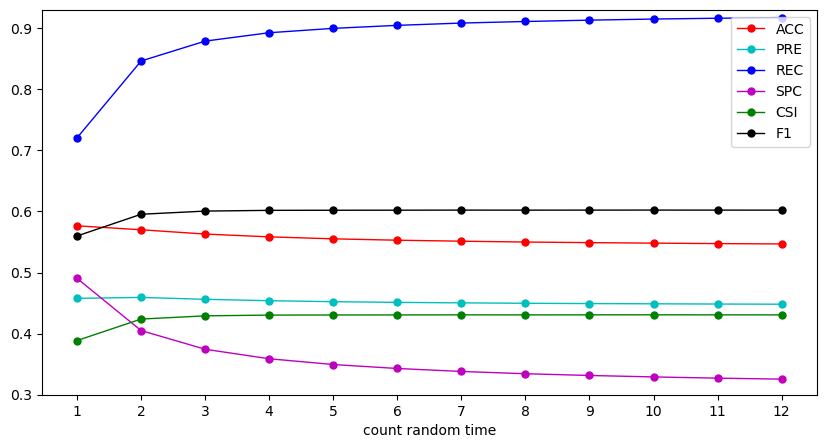

In [18]:
plt.figure(figsize = (10,5))
X = range(1,13)
plt.plot(X,ACC_tb, c = 'r', lw=1, marker='o', ms=5, label='ACC')
plt.plot(X,PRE_tb, c = 'c', lw=1, marker='o', ms=5, label='PRE')
plt.plot(X,REC_tb, c = 'b', lw=1, marker='o', ms=5, label='REC')
plt.plot(X,SPC_tb, c = 'm', lw=1, marker='o', ms=5, label='SPC')
plt.plot(X,CSI_tb, c = 'g', lw=1, marker='o', ms=5, label='CSI')
plt.plot(X,F1_tb, c = 'k', lw=1, marker='o', ms=5, label='F1')
plt.ylim(0.3,0.93)
plt.xticks(X)
plt.xlabel('count random time') 
plt.legend(loc='upper right')
output_path = 'C:/Users/LG/Desktop/frost_data/ver3/ML_kma/fig'
fig_out = os.path.join(output_path, os.path.basename('rf_kma_ck_T')+'.jpg')
plt.savefig(fig_out)

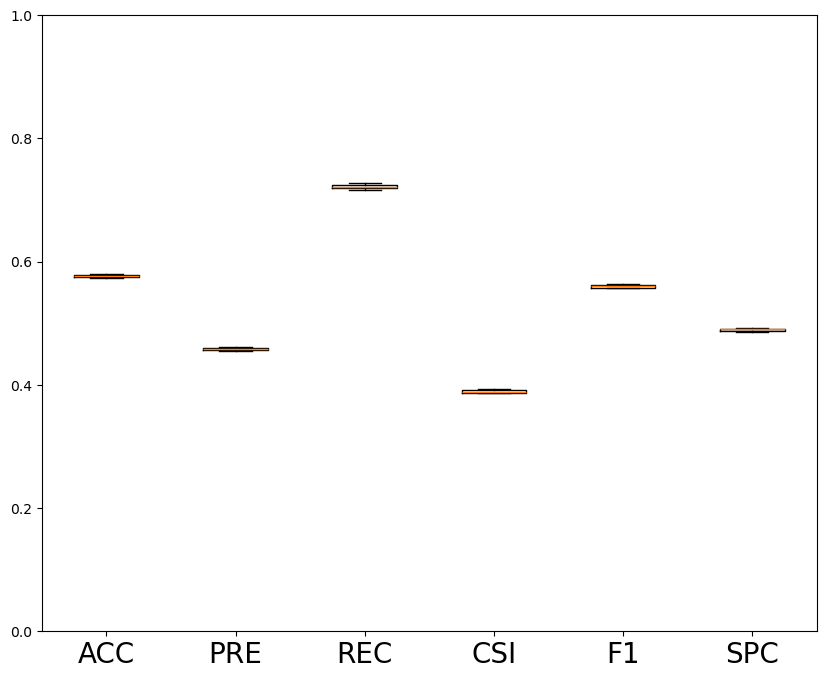

In [53]:
output_path = 'C:/Users/LG/Desktop/frost_data/ver3/ML_kma'
plt.figure(figsize = (10,8))
plt.boxplot([ACC, PRE, REC, CSI, F1, SPC])
plt.xticks([1,2,3,4,5,6],['ACC','PRE','REC','CSI','F1','SPC'],fontsize = 20)
plt.ylim(0,1)

plt.show()
fig_out = os.path.join(output_path, os.path.basename('ck_kma_frost')+'.jpg')
#plt.savefig(fig_out)

In [30]:
test_ori = test_pb
t_real_Y = total_f
i = 0
j = 0
ck_hour = 12
test_Y = []
while i + ck_hour <= test_ori.size:
    test_sample = test_ori[i:i+ck_hour]
    frost_ck = sum(test_sample)
    i += ck_hour
    if j == 0:
        test_Y = frost_ck
        j += 1
    else:
        test_Y = np.hstack((test_Y,frost_ck))

total_tb = pd.DataFrame(np.c_[test_Y, t_real_Y])
total_tb = total_tb.dropna(axis=0)
total_tb = np.array(total_tb.iloc[:,:],float)
total_tb = total_tb[total_tb[:,1] == 1]
#print(total_tb)
test_Y = total_tb[:,0]
t_real_Y = total_tb[:,1]

X = range(0,13)
Y_od = list(test_Y)
print(Y_od.count(1))
for i in range(0,13):
    ck_Y = Y_od.count(int(i))
    if i == 0:
        Y = ck_Y
    else:
        Y = np.hstack((Y,ck_Y))
print(Y)

79
[ 489   79   95  100   95  119  158  216  288  895 1439  912 1018]


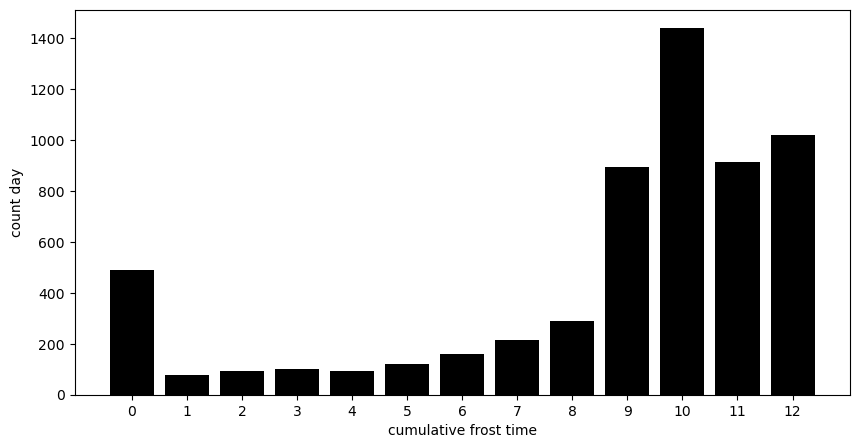

In [37]:
plt.figure(figsize = (10,5))
plt.bar(X,Y, color='k')
plt.xlabel('cumulative frost time')
plt.ylabel('count day')
plt.xticks(X)
output_path = 'C:/Users/LG/Desktop/frost_data/ver3/ML_kma/fig'
fig_out = os.path.join(output_path, os.path.basename('rf_kma_ck_T_hist')+'.jpg')
plt.savefig(fig_out)